In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jdcal import gcal2jd
import matplotlib.dates as mdates
from brokenaxes import brokenaxes
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [12]:
# To use LaTeX and select Helvetica as the default font, without editing matplotlibrc use:
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
### for Palatino and other serif fonts use:
##rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

#plt.rc('text', usetex=True)
#plt.rc('text.latex', preamble=r'\usepackage{physics}')
#plt.rc('font', family='serif')

In [21]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

#params = {'text.latex.preamble':[r'\usepackage{siunitx}',
#                                 r'\usepackage{amsmath}',
#                                 r'\usepackage{physics}',
#                                 r'\usepackage{sfmath}',
#                                 r'\sisetup{detect-all=true}']}

params = {'text.usetex':True,
          'font.family':'serif',
          'font.sans-serif':'cm',
          'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{mathptmx}',
                                 r'\sisetup{detect-all=true}',
                                 r'\DeclareSIUnit\inch{in}',
                                 r'\DeclareSIUnit\gauss{G}'],
          'mathtext.fontset':'cm',
          'timezone':None,
          'xtick.labelsize':14,
          'ytick.labelsize':14, 
          'legend.fontsize':18, 
          'axes.labelsize':18,}
plt.rcParams.update(params)

In [22]:
# Wavemeter long-term drift
wm_drift = pd.read_csv('Wavemeter_Calibration_Data-689nm.csv')

# Convert 'Date measured' to datetime object, calculate modified Julian date
#wm_drift['Date measured'] = wm_drift['Date measured'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d'))
wm_drift['Date measured'] = pd.to_datetime(wm_drift['Date measured'])
wm_drift['MJD'] = wm_drift['Date measured'].apply(lambda x: gcal2jd(x.year, x.month, x.day)[1])

In [23]:
# Calculate weighted average and weighted standard deviation
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

wm_drift_avg, wm_drift_std = weighted_avg_and_std(wm_drift['Deviation [MHz]'], 1/wm_drift['Deviation (std.) [MHz]']**2)

## Original plot

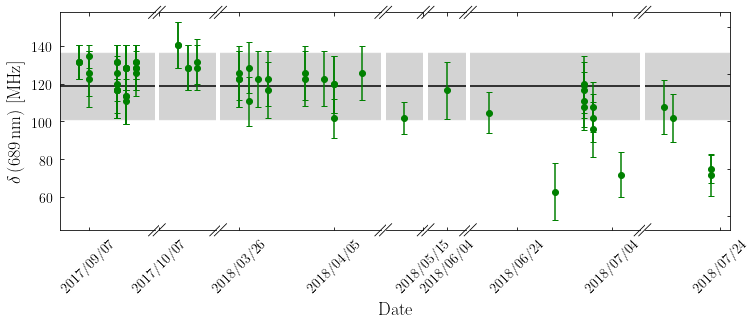

In [27]:
#rc_params = {'font.family':'arial',
#             'xtick.labelsize':14,
#             'ytick.labelsize':14, 
#             'legend.fontsize':18, 
#             'axes.labelsize':18}

rc_params = {'xtick.labelsize':14,
             'ytick.labelsize':14, 
             'legend.fontsize':18, 
             'axes.labelsize':18,
             'text.usetex':True,
             'text.latex.preamble':r'\usepackage{physics}',
             'font.family':'serif',
             'timezone':None}

with plt.rc_context(rc_params):
    fig = plt.figure(figsize = (12,4))
    
    # Converts datetime to a format matplotlib can easily plot
    x = mdates.num2date(mdates.date2num(wm_drift['Date measured']))
    
    xmin = mdates.num2date(np.min(mdates.date2num(wm_drift['Date measured']))-2)
    xmax = mdates.num2date(np.max(mdates.date2num(wm_drift['Date measured']))+2)
    
    # Try using mdates.date2num(datetime.datetime(2017, 9, 13)) to figure out date number
    
    bax = brokenaxes(xlims=((xmin, mdates.num2date(736585+2)),
                            (mdates.num2date(736612-2), mdates.num2date(736614+2)),
                            (mdates.num2date(736780-2), mdates.num2date(736793+2)),
                            (mdates.num2date(736828-2), mdates.num2date(736828+2)),
                            (mdates.num2date(736850-2), mdates.num2date(736850+2)),
                            (mdates.num2date(736867-2), mdates.num2date(736881+2)),
                            (mdates.num2date(736894-2), xmax)),
                            wspace=0.05, despine = False, d=0.01)
    
    bax.errorbar(x, wm_drift['Deviation [MHz]'], yerr = wm_drift['Deviation (std.) [MHz]'], 
                 fmt='o', capsize=3, color='green', zorder=2)
    
    x = np.linspace(mdates.date2num(xmin), mdates.date2num(xmax), 1000)
    y = np.linspace(wm_drift_avg, wm_drift_avg, 1000)
    
    #label_str = 'Weighted avg. (%s) MHz' % ufloat(wm_drift_avg, wm_drift_std)
    bax.plot(mdates.num2date(x), y, linestyle='-', color='black', zorder=1)
    bax.fill_between(mdates.num2date(x), y + wm_drift_std, y - wm_drift_std, color='lightgray', zorder=0)
    
    bax.set_ylabel(r'$\delta\left(\mathrm{689\,nm}\right)$ [MHz]', labelpad=35)
    bax.set_xlabel(r'Date', labelpad=70)
    
    for i, ax in enumerate(bax.axs):
        plt.sca(ax)
        plt.xticks(rotation=45)
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
        
        ax.tick_params(which='both', axis='both', direction='in', pad=8)
        
        ax.xaxis.set_ticks_position('both')
    
    bax.axs[-1].tick_params(which='both', axis='both', direction='in', pad=8, left=False, right=True)
    bax.axs[-1].set_yticks([50, 75, 100, 125, 150])
    bax.axs[-1].set_yticklabels(['','','','',''])
    
    #plt.savefig('wm_drift.svg', bbox_inches='tight', transparent=True)
    plt.show()

## New plot for thesis

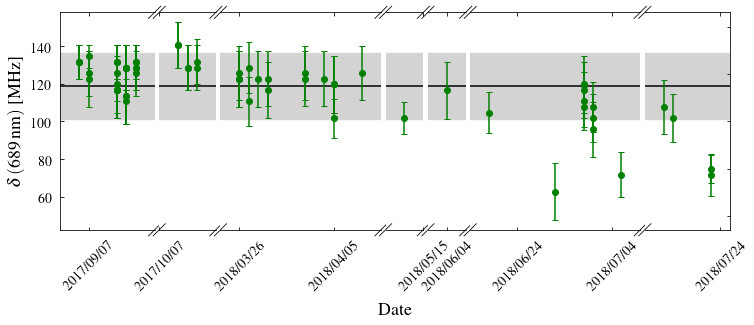

In [28]:
fig = plt.figure(figsize = (12,4))

# Converts datetime to a format matplotlib can easily plot
x = mdates.num2date(mdates.date2num(wm_drift['Date measured']))

xmin = mdates.num2date(np.min(mdates.date2num(wm_drift['Date measured']))-2)
xmax = mdates.num2date(np.max(mdates.date2num(wm_drift['Date measured']))+2)

# Try using mdates.date2num(datetime.datetime(2017, 9, 13)) to figure out date number

bax = brokenaxes(xlims=((xmin, mdates.num2date(736585+2)),
                        (mdates.num2date(736612-2), mdates.num2date(736614+2)),
                        (mdates.num2date(736780-2), mdates.num2date(736793+2)),
                        (mdates.num2date(736828-2), mdates.num2date(736828+2)),
                        (mdates.num2date(736850-2), mdates.num2date(736850+2)),
                        (mdates.num2date(736867-2), mdates.num2date(736881+2)),
                        (mdates.num2date(736894-2), xmax)),
                        wspace=0.05, despine = False, d=0.01)

bax.errorbar(x, wm_drift['Deviation [MHz]'], yerr = wm_drift['Deviation (std.) [MHz]'], 
             fmt='o', capsize=3, color='green', zorder=2)

x = np.linspace(mdates.date2num(xmin), mdates.date2num(xmax), 1000)
y = np.linspace(wm_drift_avg, wm_drift_avg, 1000)

#label_str = 'Weighted avg. (%s) MHz' % ufloat(wm_drift_avg, wm_drift_std)
bax.plot(mdates.num2date(x), y, linestyle='-', color='black', zorder=1)
bax.fill_between(mdates.num2date(x), y + wm_drift_std, y - wm_drift_std, color='lightgray', zorder=0)

bax.set_ylabel(r'$\delta\left(\mathrm{689\,nm}\right)$ [MHz]', labelpad=35)
bax.set_xlabel(r'Date', labelpad=70)

for i, ax in enumerate(bax.axs):
    plt.sca(ax)
    plt.xticks(rotation=45)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))

    ax.tick_params(which='both', axis='both', direction='in', pad=8)

    ax.xaxis.set_ticks_position('both')

bax.axs[-1].tick_params(which='both', axis='both', direction='in', pad=8, left=False, right=True)
bax.axs[-1].set_yticks([50, 75, 100, 125, 150])
bax.axs[-1].set_yticklabels(['','','','',''])

plt.savefig('wm_drift.pdf', bbox_inches='tight', transparent=True)
plt.show()